<a href="https://colab.research.google.com/github/samuel-verburg/EEA-summer-school-2025/blob/main/exercise2_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### EEA Summer School 2025: Measurement Methods for Sound Field Analysis, Reconstruction, and Reproduction
**Exercise 2: Machine learning and Physics-informed neural networks for sound field reconstruction**

**Introduction**

Machine learning...  Physics-informed neural networks (PINNs)

In this notebook, you will learn to:
- Create a neural network using Pytorch.
- Train a neural network to solve a sound field reconstruction problem.
- Incorporate physical constrains to train a PINN. 

To create and train the neural networks, we are going to use [`Pytorch`](https://pytorch.org/). We run the models in CPU, but the notebook can be eaily modified to run on GPU. Just define your device using something like

`device = 'cuda:0' if torch.cuda.is_available() else 'cpu'`

and move the tensors to and from the device. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch as torch
import torch.nn as nn
from tqdm import tqdm

We start by defining a class for fully connected neural networks (FCN). In the fully connected architecture each neuron in one layer is connected to every neuron in the next layer. 

<img src="FCN.png" alt="Fully Connected Network architecture" width="400"/>

Fig. from [Tonello2019]

We will use *sines* as activation function. Using a sine function is beneficial for tasks involving learning high-frequency functions or representing complex signals, because they are periodic, smooth, and infinitely differentiable. This allows the network to model continuous signals more effectively than traditional activations like ReLU or tanh.

In [ ]:
class Sin(nn.Module):
    """Sin activation function"""
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class FCN(nn.Module):
    """Fully Connected Network."""
    def __init__(self, n_in, n_out, n_units, n_layers):
        super().__init__()
        activation = Sin
        self.fcs = nn.Sequential(*[
                        nn.Linear(n_in, n_units),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                        nn.Linear(n_units, n_units),
                        activation()]) for _ in range(n_layers-1)])
        self.fce = nn.Linear(n_units, n_out)
    def forward(self, r):
        r = self.fcs(r)
        r = self.fch(r)
        r = self.fce(r)
        return r

In [8]:
# Define parameters
c = 343.0
f = 1000.0
k = 2 * np.pi * f / c
L = 1.0
T = 1e-3

r = np.linspace(0.1, L, 50)
t = np.linspace(0, T, 50)
r_grid, t_grid = np.meshgrid(r, t)
rt = np.array([r_grid.flatten(), t_grid.flatten()]).T

p_ref = np.exp(1j * (2 * np.pi * f * rt[:, 1] - k * rt[:, 0])) / (4 * np.pi * rt[:, 0])
p_ref = p_ref.real.reshape(r_grid.shape)

KeyboardInterrupt: 

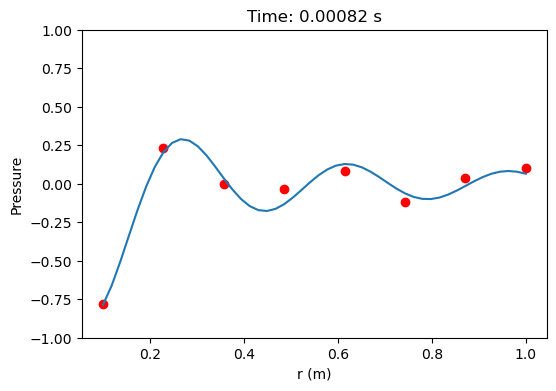

In [9]:
np.random.seed(42)
torch.manual_seed(42)
skip = 7
p_obs = p_ref[:, 0::skip].copy()
p_obs += 0.2 * np.random.randn(p_obs.shape[0],p_obs.shape[1]) * np.sqrt(np.mean(np.abs(p_obs)**2))
r_obs = r[0::skip]
rt_obs = np.array([r_grid[:, 0::skip].flatten(), t_grid[:, 0::skip].flatten()]).T

fig = plt.figure(figsize=(6, 4))
line, = plt.plot(r, p_ref[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line.set_ydata(p_ref[frame, :])
    for coll in plt.gca().collections:
        coll.remove()
    plt.scatter(r_obs, p_obs[frame, :], color='red', label='Observations')
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line,

ani = FuncAnimation(fig, update, frames=p_ref.shape[0], interval=100, blit=True)
# ani.save('wave_animation.gif', writer='pillow', fps=10)
# ani

html = HTML(ani.to_jshtml())
display(html)
plt.close()


In [ ]:
n_in = 2
n_out = 1
n_hidden = 32
n_layers = 3
n_epochs = int(4e4)

rt_obs = torch.tensor(rt_obs, dtype=torch.float32).requires_grad_(True)
p_obs = torch.tensor(p_obs.reshape(-1,1), dtype=torch.float32).requires_grad_(True)
rt = torch.tensor(rt, dtype=torch.float32).requires_grad_(True)

model = FCN(n_in, n_out, n_hidden, n_layers)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model(rt_obs)
    loss = mse_loss(p, p_obs)

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
    loss_history.append(loss.item())

    if i % 1000 == 0:
      print('Loss:', loss.item())


  0%|          | 46/40000 [00:00<01:28, 453.23it/s]

Loss: 0.07993398606777191


  3%|▎         | 1094/40000 [00:01<01:02, 623.51it/s]

Loss: 0.05452483519911766


  5%|▌         | 2064/40000 [00:03<01:01, 617.07it/s]

Loss: 0.05499554052948952


  8%|▊         | 3061/40000 [00:05<01:20, 461.24it/s]

Loss: 0.05375553295016289


 10%|█         | 4108/40000 [00:07<00:58, 609.68it/s]

Loss: 0.052873048931360245


 13%|█▎        | 5126/40000 [00:09<00:56, 612.78it/s]

Loss: 0.03177253156900406


 15%|█▌        | 6111/40000 [00:10<00:56, 597.50it/s]

Loss: 0.030073266476392746


 18%|█▊        | 7086/40000 [00:12<00:59, 556.55it/s]

Loss: 0.029779231175780296


 20%|██        | 8117/40000 [00:14<00:53, 593.15it/s]

Loss: 0.02939205802977085


 23%|██▎       | 9070/40000 [00:15<00:55, 560.81it/s]

Loss: 0.02883419208228588


 25%|██▌       | 10044/40000 [00:17<01:12, 412.67it/s]

Loss: 0.028335552662611008


 28%|██▊       | 11085/40000 [00:20<00:49, 586.62it/s]

Loss: 0.027547189965844154


 30%|███       | 12061/40000 [00:21<00:47, 593.83it/s]

Loss: 0.025520799681544304


 33%|███▎      | 13083/40000 [00:23<00:45, 596.23it/s]

Loss: 0.023201629519462585


 35%|███▌      | 14064/40000 [00:25<01:00, 426.93it/s]

Loss: 0.021817831322550774


 38%|███▊      | 15109/40000 [00:27<00:44, 554.56it/s]

Loss: 0.020760737359523773


 40%|████      | 16048/40000 [00:29<00:47, 509.47it/s]

Loss: 0.018790269270539284


 43%|████▎     | 17088/40000 [00:32<00:47, 480.73it/s]

Loss: 0.01681615225970745


 45%|████▌     | 18087/40000 [00:33<00:37, 577.88it/s]

Loss: 0.013362380675971508


 48%|████▊     | 19064/40000 [00:35<00:34, 602.90it/s]

Loss: 0.006305051036179066


 50%|█████     | 20086/40000 [00:37<00:35, 559.62it/s]

Loss: 0.004525260534137487


 53%|█████▎    | 21077/40000 [00:38<00:32, 583.99it/s]

Loss: 0.004432687535881996


 55%|█████▌    | 22118/40000 [00:40<00:29, 599.71it/s]

Loss: 0.0034333437215536833


 58%|█████▊    | 23066/40000 [00:42<00:41, 406.34it/s]

Loss: 0.004731972701847553


 60%|██████    | 24067/40000 [00:44<00:29, 549.32it/s]

Loss: 0.003287956351414323


 63%|██████▎   | 25071/40000 [00:46<00:27, 550.21it/s]

Loss: 0.002767921658232808


 65%|██████▌   | 26088/40000 [00:48<00:23, 588.89it/s]

Loss: 0.002621197374537587


 68%|██████▊   | 27081/40000 [00:50<00:21, 589.78it/s]

Loss: 0.0025150617584586143


 70%|███████   | 28119/40000 [00:51<00:19, 610.08it/s]

Loss: 0.002439621603116393


 73%|███████▎  | 29102/40000 [00:53<00:18, 585.14it/s]

Loss: 0.002410132670775056


 75%|███████▌  | 30068/40000 [00:55<00:24, 413.52it/s]

Loss: 0.0023302631452679634


 78%|███████▊  | 31052/40000 [00:57<00:17, 521.81it/s]

Loss: 0.0022635271307080984


 80%|████████  | 32070/40000 [00:59<00:12, 612.12it/s]

Loss: 0.0022156110499054193


 83%|████████▎ | 33109/40000 [01:01<00:11, 583.33it/s]

Loss: 0.002197060501202941


 85%|████████▌ | 34081/40000 [01:03<00:10, 577.49it/s]

Loss: 0.00218768697232008


 88%|████████▊ | 35104/40000 [01:04<00:08, 567.46it/s]

Loss: 0.002166913589462638


 90%|█████████ | 36115/40000 [01:06<00:06, 580.23it/s]

Loss: 0.0021099706646054983


 93%|█████████▎| 37037/40000 [01:08<00:07, 403.66it/s]

Loss: 0.002089420799165964


 95%|█████████▌| 38103/40000 [01:10<00:03, 567.60it/s]

Loss: 0.0020736954174935818


 98%|█████████▊| 39094/40000 [01:12<00:01, 530.89it/s]

Loss: 0.0022330726496875286


100%|██████████| 40000/40000 [01:14<00:00, 537.20it/s]


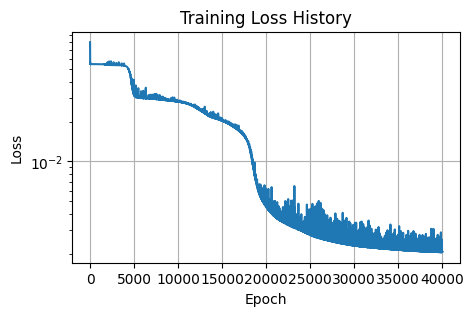

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(np.array(loss_history))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss History')
ax.set_yscale("log")
ax.grid()
plt.show()

In [ ]:
p_rec = model(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line1, = plt.plot(r, p_ref[0, :])
line2, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line1.set_ydata(p_ref[frame, :])
    line2.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line1, line2

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
# ani.save('wave_animation_model.gif', writer='pillow', fps=10)
# ani

html = HTML(ani.to_jshtml())
display(html)
plt.close()

In [ ]:
def pde_residual(p, rt, c):
    p_rt = torch.autograd.grad(p, rt, torch.ones_like(p), create_graph=True)[0]
    p_rr = torch.autograd.grad(p_rt[:,0], rt, torch.ones_like(p_rt[:,0]), create_graph=True)[0][:,0:1]
    p_tt = torch.autograd.grad(p_rt[:,1], rt, torch.ones_like(p_rt[:,1]), create_graph=True)[0][:,1:2]
    pde_res = p_rr - p_tt / c**2
    return pde_res

alpha = 1e-3
model_pinn = FCN(n_in, n_out, n_hidden, n_layers)
# model_pinn = model
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

n_epochs = int(4e4)


In [ ]:

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    p = model_pinn(rt_obs)
    loss_obs = mse_loss(p, p_obs)

    # if i < int(n_epochs/2):
    #   loss_pde = loss_obs*0
    # else:
    r_colloc = torch.randn_like(rt_obs, dtype=torch.float32, requires_grad=True) * torch.tensor([L, T])
    p = model_pinn(r_colloc)
    loss_pde = mse_loss(pde_residual(p, r_colloc, c), torch.zeros_like(p))

      # p = model_pinn(rt)
      # loss_pde = mse_loss(pde_residual(p, rt, c), torch.zeros_like(p))

    loss = loss_obs + loss_pde*alpha

    # backpropagate
    loss.backward()
    optimizer.step()
    if i == 0:
        loss_history = []
        loss_obs_history = []
        loss_pde_history = []

    loss_history.append(loss.item())
    loss_obs_history.append(loss_obs.item())
    loss_pde_history.append(loss_pde.item())

    if i % 1000 == 0:
      print(loss)


  0%|          | 8/40000 [00:00<09:08, 72.95it/s]

tensor(0.1078, grad_fn=<AddBackward0>)


  3%|▎         | 1017/40000 [00:09<05:10, 125.59it/s]

tensor(0.0545, grad_fn=<AddBackward0>)


  5%|▌         | 2025/40000 [00:18<04:54, 128.78it/s]

tensor(0.0545, grad_fn=<AddBackward0>)


  8%|▊         | 3011/40000 [00:26<06:36, 93.18it/s]

tensor(0.0537, grad_fn=<AddBackward0>)


 10%|█         | 4018/40000 [00:35<04:37, 129.49it/s]

tensor(0.0535, grad_fn=<AddBackward0>)


 13%|█▎        | 5021/40000 [00:44<04:40, 124.55it/s]

tensor(0.0515, grad_fn=<AddBackward0>)


 15%|█▌        | 6016/40000 [00:52<06:50, 82.81it/s]

tensor(0.0496, grad_fn=<AddBackward0>)


 18%|█▊        | 7026/40000 [01:00<04:27, 123.42it/s]

tensor(0.0489, grad_fn=<AddBackward0>)


 20%|██        | 8018/40000 [01:09<04:17, 124.23it/s]

tensor(0.0476, grad_fn=<AddBackward0>)


 23%|██▎       | 9016/40000 [01:18<04:47, 107.93it/s]

tensor(0.0449, grad_fn=<AddBackward0>)


 25%|██▌       | 10020/40000 [01:26<03:56, 126.81it/s]

tensor(0.0438, grad_fn=<AddBackward0>)


 28%|██▊       | 11020/40000 [01:35<03:55, 123.30it/s]

tensor(0.0404, grad_fn=<AddBackward0>)


 30%|███       | 12023/40000 [01:43<03:51, 120.94it/s]

tensor(0.0378, grad_fn=<AddBackward0>)


 33%|███▎      | 13022/40000 [01:51<03:32, 126.89it/s]

tensor(0.0359, grad_fn=<AddBackward0>)


 35%|███▌      | 14024/40000 [02:00<03:19, 130.53it/s]

tensor(0.0316, grad_fn=<AddBackward0>)


 38%|███▊      | 15027/40000 [02:09<03:14, 128.32it/s]

tensor(0.0113, grad_fn=<AddBackward0>)


 40%|████      | 16018/40000 [02:17<03:05, 129.07it/s]

tensor(0.0072, grad_fn=<AddBackward0>)


 43%|████▎     | 17016/40000 [02:25<02:58, 128.91it/s]

tensor(0.0068, grad_fn=<AddBackward0>)


 45%|████▌     | 18022/40000 [02:34<02:44, 133.75it/s]

tensor(0.0063, grad_fn=<AddBackward0>)


 48%|████▊     | 19016/40000 [02:42<02:40, 130.40it/s]

tensor(0.0063, grad_fn=<AddBackward0>)


 50%|█████     | 20018/40000 [02:51<02:34, 129.20it/s]

tensor(0.0064, grad_fn=<AddBackward0>)


 53%|█████▎    | 21026/40000 [02:59<02:22, 132.99it/s]

tensor(0.0064, grad_fn=<AddBackward0>)


 55%|█████▌    | 22024/40000 [03:07<02:17, 130.40it/s]

tensor(0.0062, grad_fn=<AddBackward0>)


 58%|█████▊    | 23026/40000 [03:16<02:12, 128.00it/s]

tensor(0.0068, grad_fn=<AddBackward0>)


 60%|██████    | 24025/40000 [03:24<02:04, 128.63it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 63%|██████▎   | 25018/40000 [03:32<02:01, 123.61it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 65%|██████▌   | 26020/40000 [03:41<01:45, 132.62it/s]

tensor(0.0062, grad_fn=<AddBackward0>)


 68%|██████▊   | 27025/40000 [03:49<01:41, 128.14it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 70%|███████   | 28024/40000 [03:57<01:34, 126.18it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 73%|███████▎  | 29022/40000 [04:06<01:25, 127.85it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 75%|███████▌  | 30024/40000 [04:14<01:19, 126.27it/s]

tensor(0.0062, grad_fn=<AddBackward0>)


 78%|███████▊  | 31028/40000 [04:22<01:07, 132.16it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 80%|████████  | 32027/40000 [04:31<00:58, 136.09it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 83%|████████▎ | 33022/40000 [04:39<00:50, 137.39it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 85%|████████▌ | 34026/40000 [04:47<00:45, 132.18it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 88%|████████▊ | 35027/40000 [04:56<00:41, 119.22it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 90%|█████████ | 36019/40000 [05:04<00:30, 131.57it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 93%|█████████▎| 37016/40000 [05:12<00:24, 121.54it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


 95%|█████████▌| 38009/40000 [05:20<00:15, 125.13it/s]

tensor(0.0061, grad_fn=<AddBackward0>)


 98%|█████████▊| 39025/40000 [05:29<00:07, 134.17it/s]

tensor(0.0060, grad_fn=<AddBackward0>)


100%|██████████| 40000/40000 [05:36<00:00, 118.73it/s]


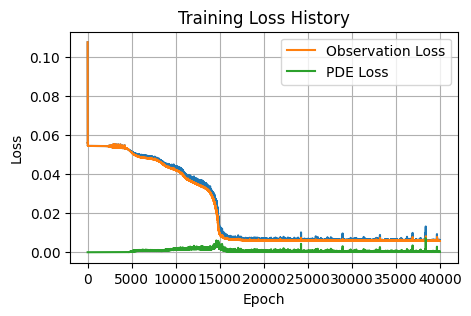

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(loss_history))
plt.plot(np.array(loss_obs_history), label='Observation Loss')
plt.plot(np.array(loss_pde_history)*alpha, label='PDE Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid()
plt.show()

In [ ]:
p_rec = model_pinn(rt).detach().numpy()
p_rec = p_rec.reshape(r_grid.shape)

fig = plt.figure(figsize=(6, 4))
line1, = plt.plot(r, p_ref[0, :])
line2, = plt.plot(r, p_rec[0, :])
plt.ylim(-1, 1)
plt.xlabel('r (m)')
plt.ylabel('Pressure')

def update(frame):
    line1.set_ydata(p_ref[frame, :])
    line2.set_ydata(p_rec[frame, :])
    plt.title(f"Time: {t_grid[frame, 0]:.5f} s")
    return line1, line2

ani = FuncAnimation(fig, update, frames=p_rec.shape[0], interval=100, blit=True)
# ani.save('wave_animation_pinn.gif', writer='pillow', fps=10)
# ani

html = HTML(ani.to_jshtml())
display(html)
plt.close()

Estimate the speed of sound

**References**

- [Tonello2019] Tonello, A., Letizia, N., Righini, D., and Marcuzzi, F. (2019). Machine Learning Tips and Tricks for Power Line Communications. IEEE Access. 7. 1-1